In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

In [30]:
root_dir ="/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/"
extra_path = ("DDims_NewLongerDriftEvalExp_MSEs_10240NPaths").replace(
            ".", "")
from configs.RecursiveVPSDE.Markovian_fBiPotDDims.recursive_Markovian_PostMeanScore_fBiPot8Dims_T256_H05_tl_110data_StbleTgt_FULLDATA import get_config as get_12dlnz_config
config = get_12dlnz_config()
nad_eval=pd.read_parquet(root_dir + extra_path+ "_nad_MSE.parquet")

score_drifts = np.load(root_dir + extra_path+ f"_{config.ts_dims}_score_drifts_at_true.npy", allow_pickle=True).reshape((1000, 1281, config.ts_dims), order="C")[:, :257, :]/256
nad_drifts = np.load(root_dir + extra_path+ f"_{config.ts_dims}_nad_drifts_at_true.npy", allow_pickle=True).reshape((1000, 1281, config.ts_dims), order="C")[:, :257, :]/256
true_drifts = np.load(root_dir + extra_path+ f"_{config.ts_dims}_true_drifts.npy", allow_pickle=True).reshape((1000, 1281, config.ts_dims), order="C")[:, :257, :]/256

score_paths = np.load(root_dir + extra_path+ f"_{config.ts_dims}_score_paths.npy", allow_pickle=True).reshape((1000, 1281, config.ts_dims), order="C")[:, :257, :]
nad_paths = np.load(root_dir + extra_path+ f"_{config.ts_dims}_nad_paths.npy", allow_pickle=True).reshape((1000, 1281, config.ts_dims), order="C")[:, :257, :]
true_paths = np.load(root_dir + extra_path+ f"_{config.ts_dims}_true_paths.npy", allow_pickle=True).reshape((1000, 1281, config.ts_dims), order="C")[:, :257, :]

score_diffs = true_paths-score_paths
idxs = np.argsort(np.sum(np.abs(score_diffs), axis=-1)[:, -1], axis=0).flatten()

true_drifts = true_drifts[idxs, :,:]#[::-1, :,:]
score_drifts = score_drifts[idxs, :,:]#[::-1,:,:]
nad_drifts = nad_drifts[idxs, :,:]#[::-1,:,:]

true_paths = true_paths[idxs, :,:]#[::-1, :,:]
score_paths = score_paths[idxs, :,:]#[::-1, :,:]
nad_paths = nad_paths[idxs, :,:]#[::-1, :,:]


In [31]:
def ctrue_drifts(device_id, config, state):
    state = torch.tensor(state, device=device_id, dtype=torch.float32)
    true_drifts = -(4. * torch.tensor(config.quartic_coeff, device=device_id, dtype=torch.float32) * torch.pow(state,
                                                                   3) + 2. * torch.tensor(config.quad_coeff,device= device_id,dtype=torch.float32) * state + torch.tensor(config.const, device=device_id, dtype=torch.float32))
    true_drifts = true_drifts/(1+config.deltaT*torch.abs(true_drifts))
    if len(true_drifts.shape) == 2:
        return true_drifts[:, np.newaxis, :]
    return true_drifts

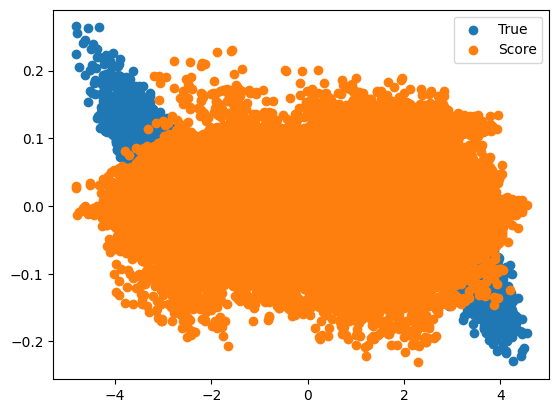

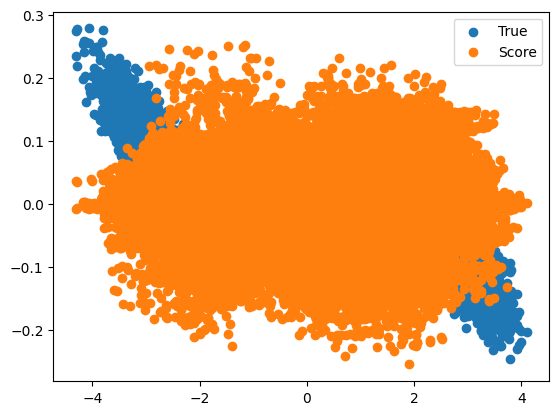

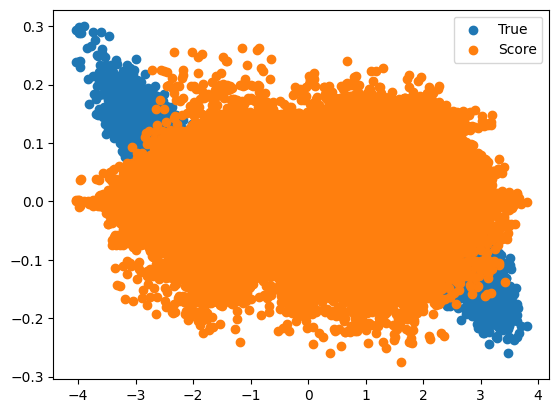

KeyboardInterrupt: 

In [32]:
for d in range(8):
    plt.scatter(true_paths[:, :, d].flatten(), true_drifts[:, :, d].flatten(), label="True")
    plt.scatter(true_paths[:, :, d].flatten(), score_drifts[:, :, d].flatten(), label="Score")
    #true_drifts_at_score_paths = ctrue_drifts(device_id="cpu", config=config, state=score_paths)
    #plt.scatter(true_paths[:, :, d].flatten(), true_drifts_at_score_paths[:, :, d].flatten(), label="True At Score")
    plt.legend()
    plt.show()
    plt.close()

In [25]:
k2 =(np.cumsum(np.nanmean(np.sum(np.power(true_drifts - nad_drifts, 2)*256*256, axis=-1), axis=0))/np.arange(1, 257+1, 1))
k2[-5:]

array([489.66700645, 489.96127661, 490.21431076, 490.50200888,
       490.72532944])

In [26]:
k3 =(np.cumsum(np.nanmean(np.sum(np.power(true_drifts - score_drifts, 2)*256*256, axis=-1), axis=0))/np.arange(1, 257+1, 1))
k3[-5:]

array([515.484417  , 515.78381577, 516.0294475 , 516.31495263,
       516.53175908])

In [27]:
time_ax = np.linspace(0, 1/256*(true_paths.shape[1]-1),true_paths.shape[1])

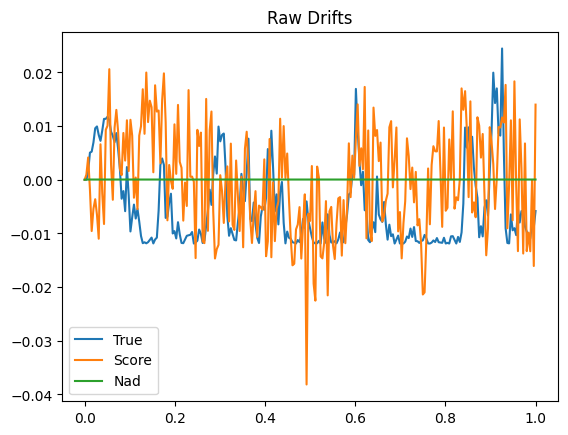

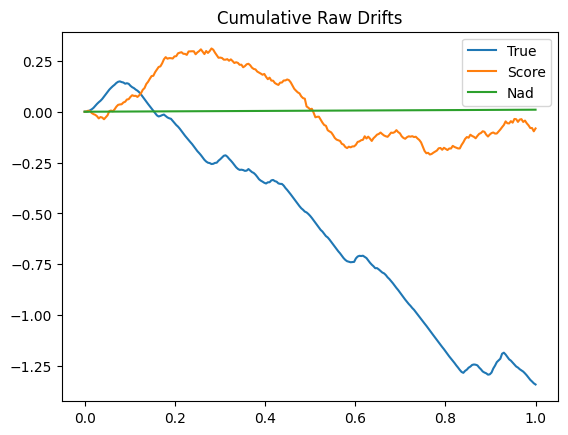

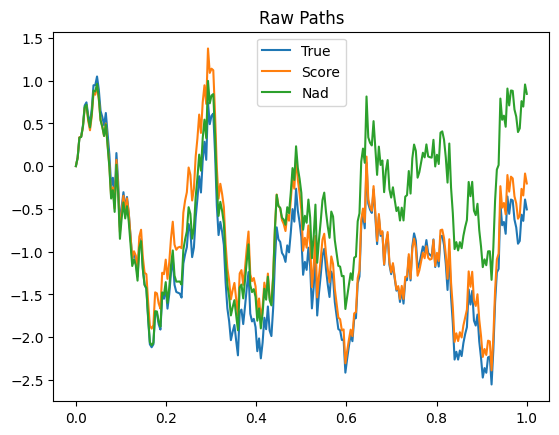

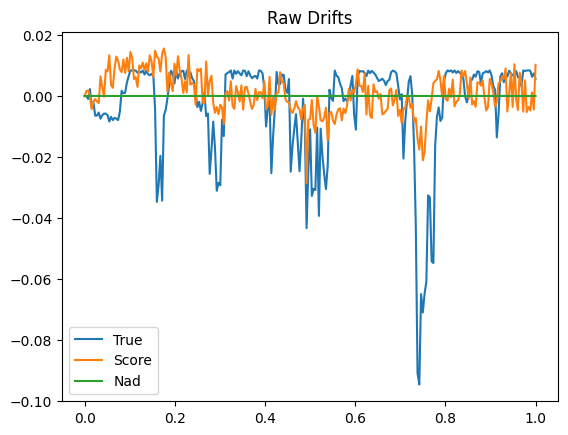

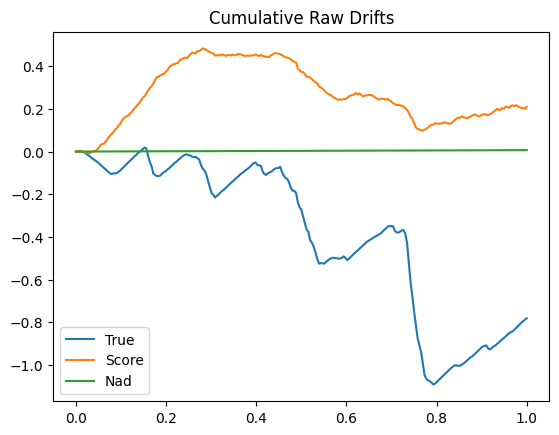

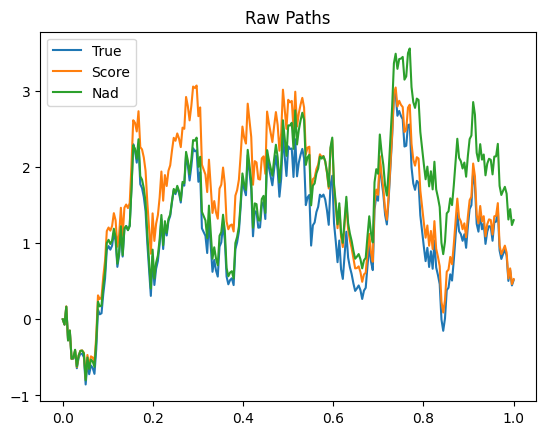

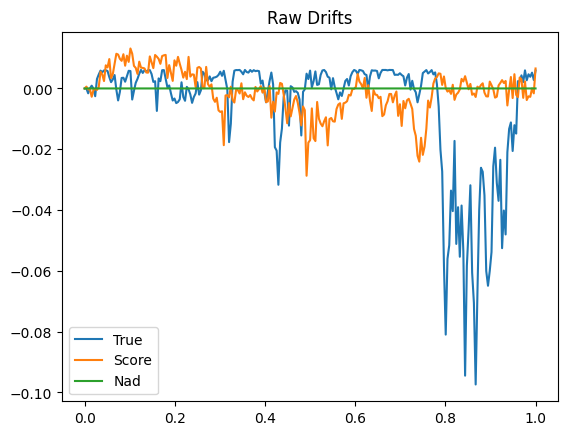

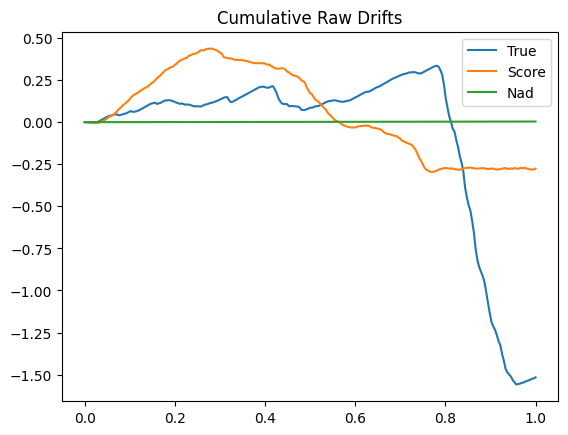

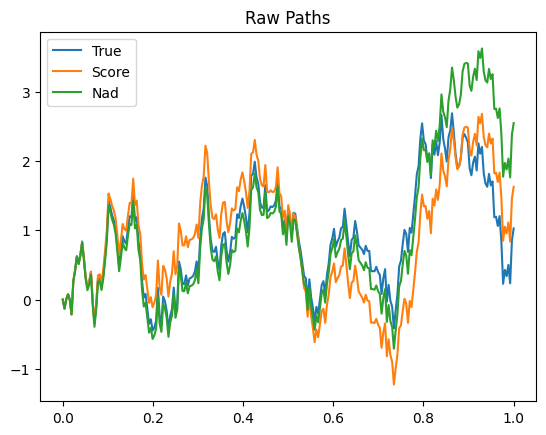

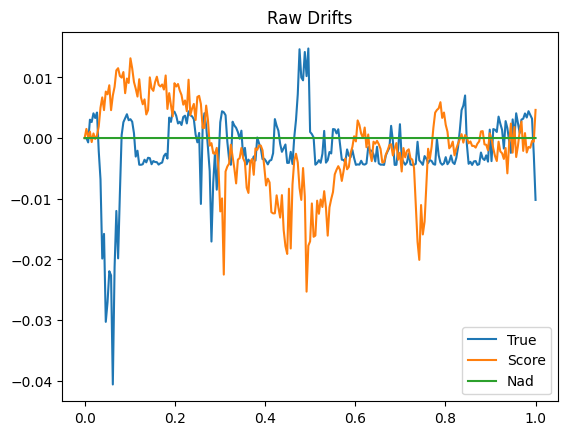

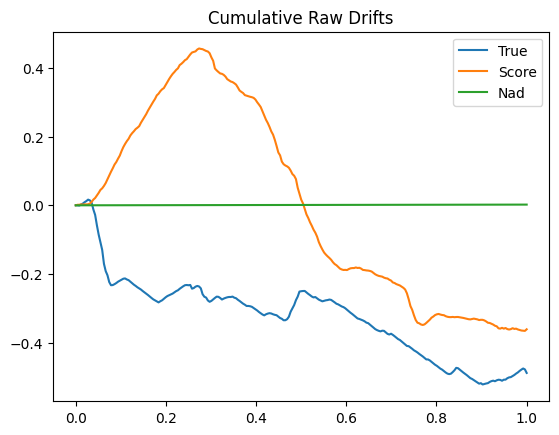

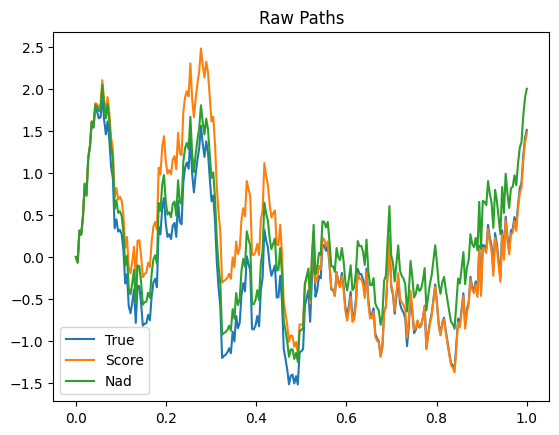

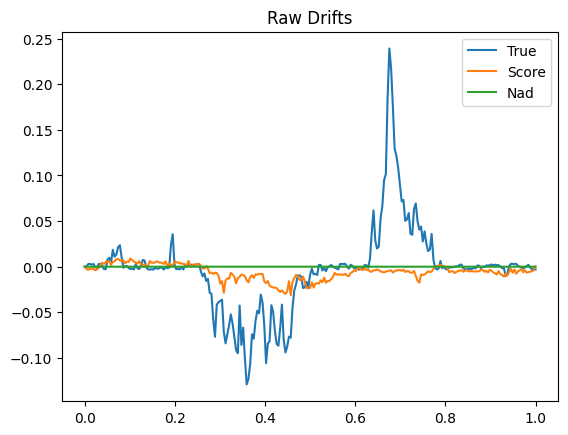

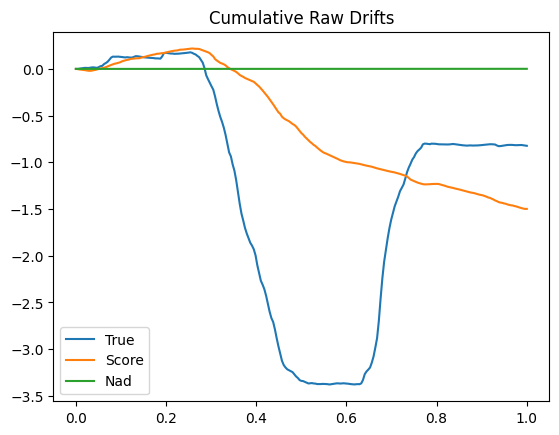

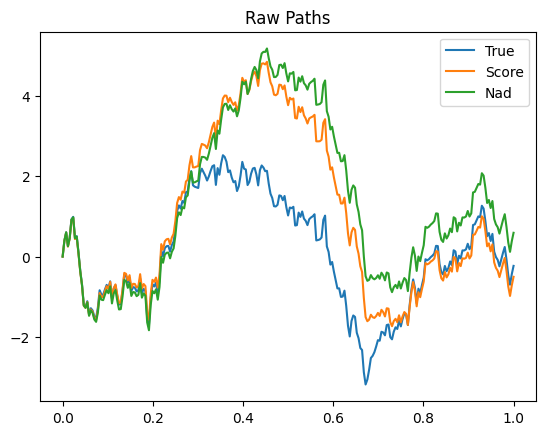

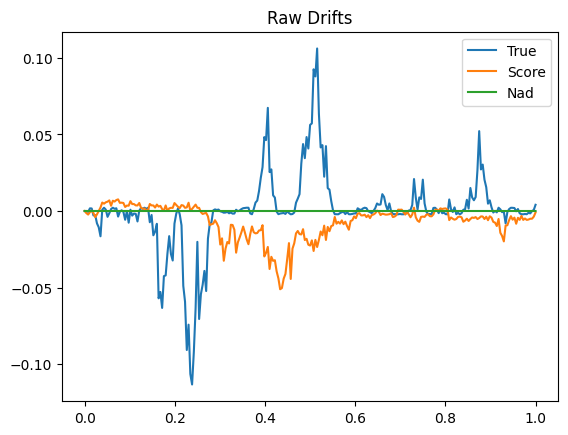

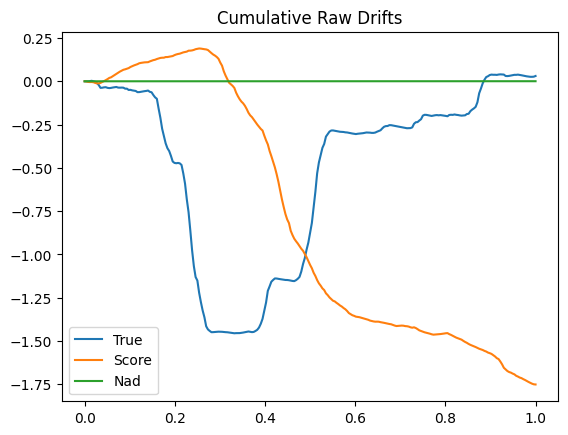

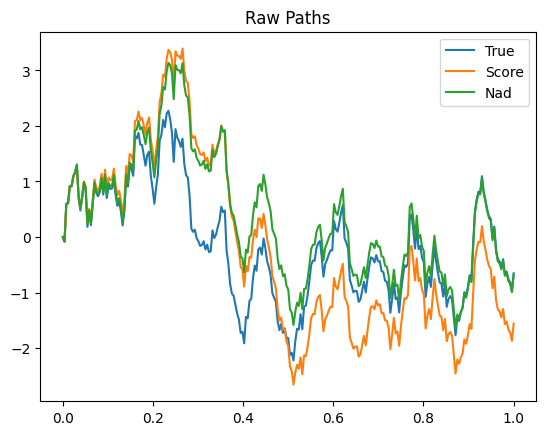

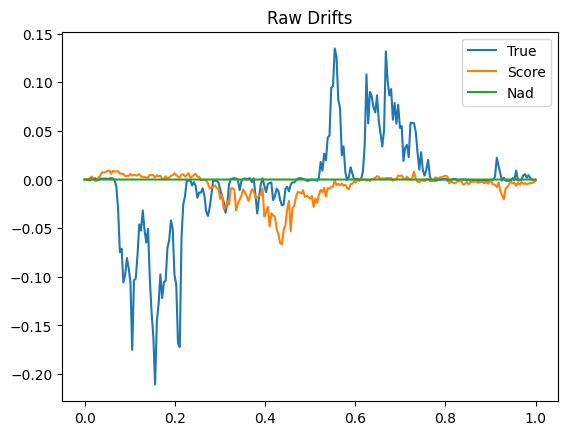

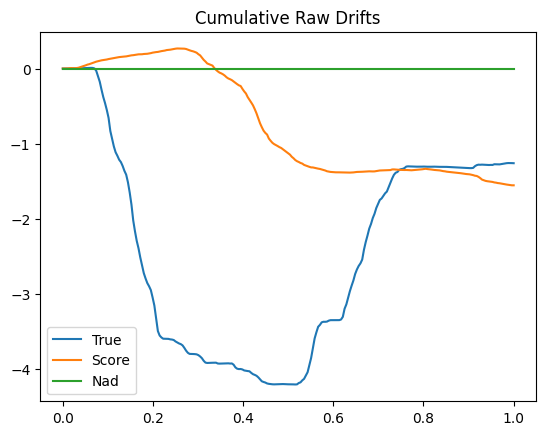

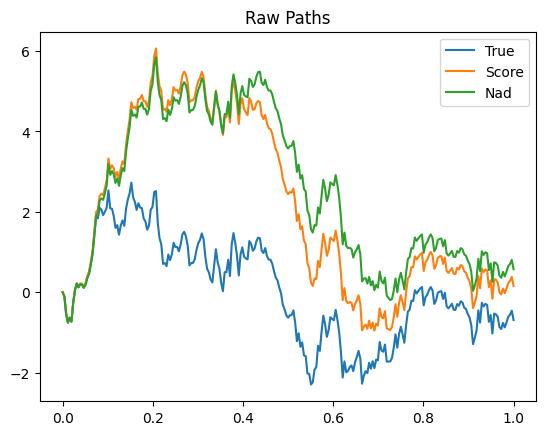

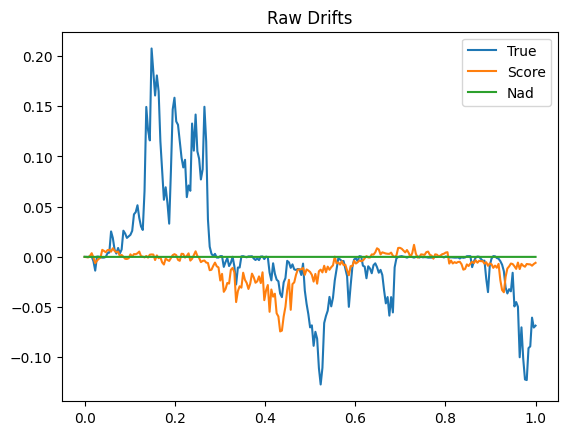

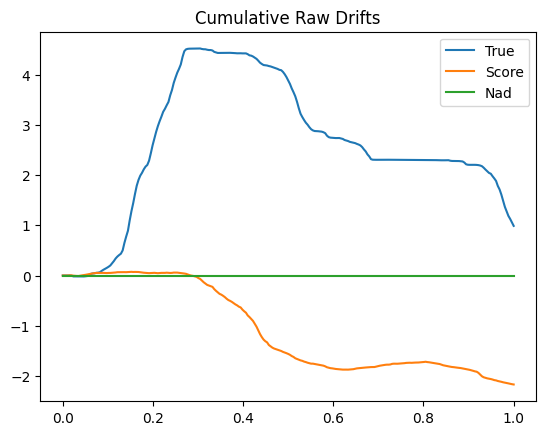

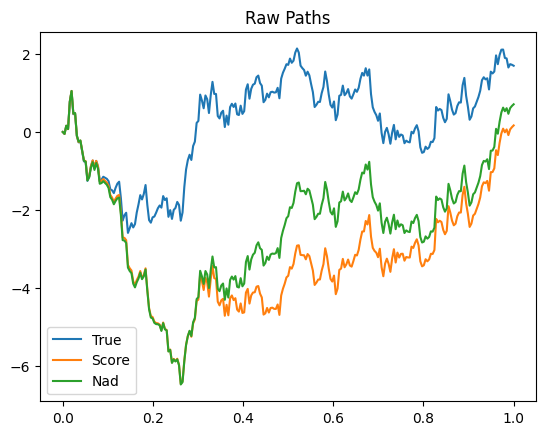

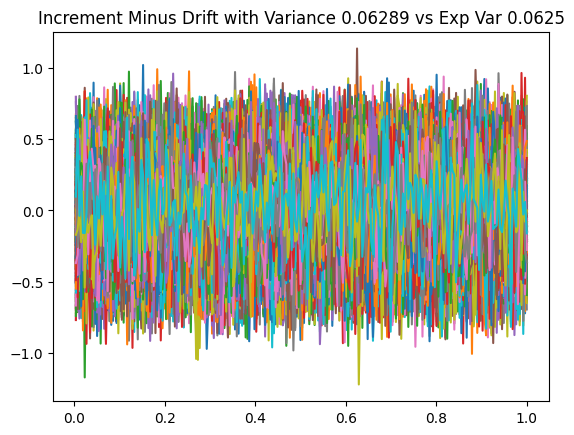

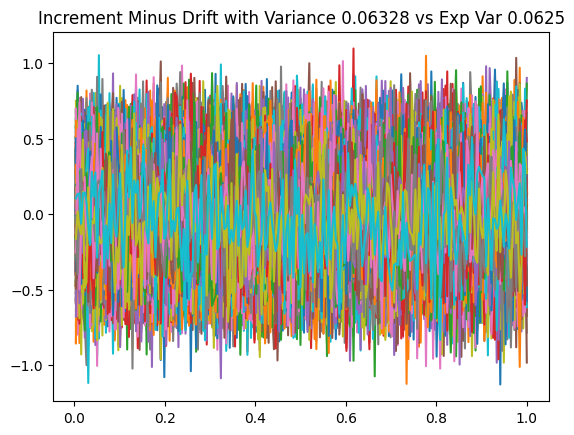

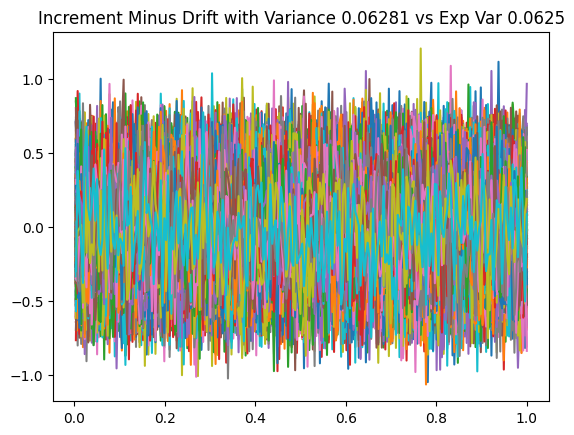

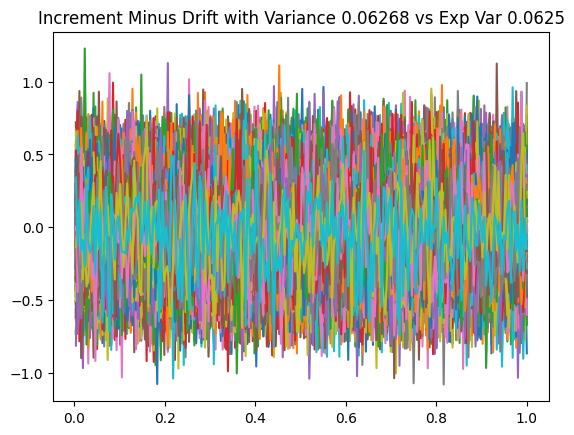

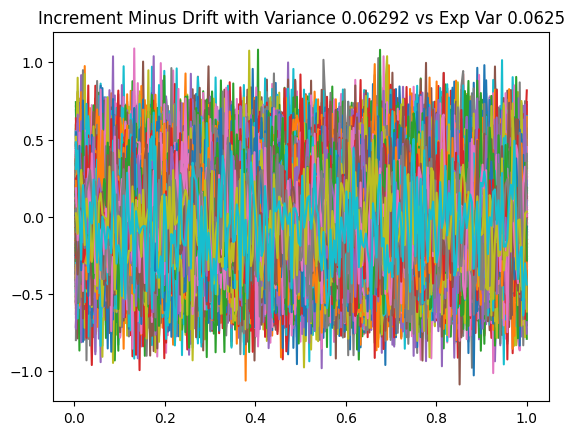

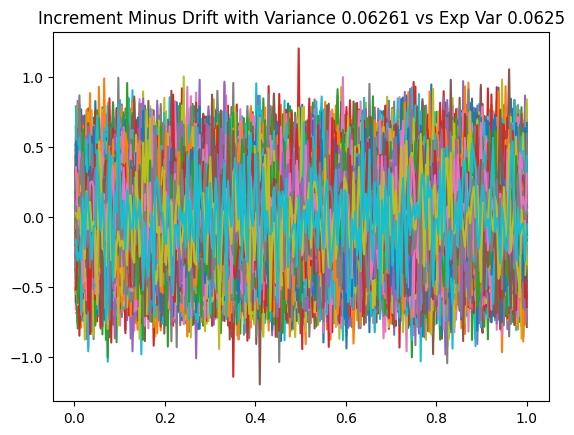

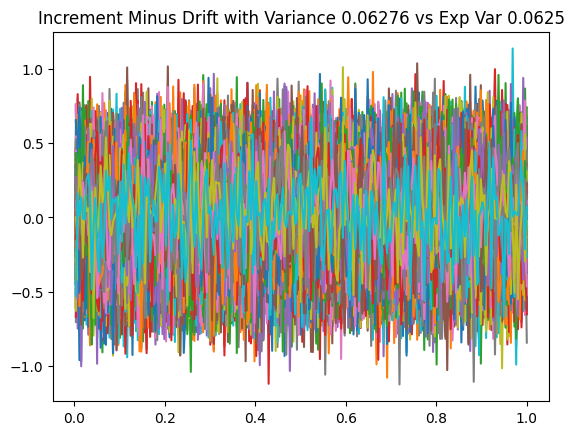

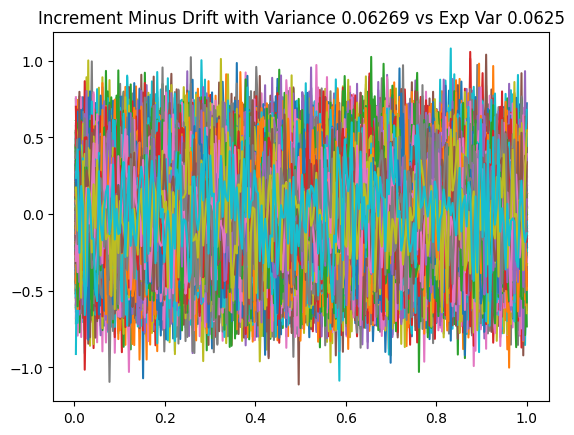

In [28]:
for k in range(1):
    for d in range(8):
        plt.plot(time_ax, true_drifts[k, :, d], label="True")
        plt.plot(time_ax, score_drifts[k, :, d], label="Score")
        plt.plot(time_ax, nad_drifts[k, :, d], label="Nad")
        plt.legend()
        plt.title("Raw Drifts")
        plt.show()
        plt.close()

        plt.plot(time_ax, np.cumsum(true_drifts[k, :, d]), label="True")
        plt.plot(time_ax, np.cumsum(score_drifts[k, :, d]), label="Score")
        plt.plot(time_ax, np.cumsum(nad_drifts[k, :, d]), label="Nad")
        plt.legend()
        plt.title("Cumulative Raw Drifts")
        plt.show()
        plt.close()

        plt.plot(time_ax, true_paths[k, :, d], label="True")
        plt.plot(time_ax, score_paths[k, :, d], label="Score")
        plt.plot(time_ax, nad_paths[k, :, d], label="Nad")
        plt.legend()
        plt.title("Raw Paths")
        plt.show()
        plt.close()

for d in range(8):
    for k in range(0, 1000):
        plt.plot(time_ax[1:], np.diff(score_paths[k, :, d]) - (score_drifts[k, 1:, d]), label="Score Difference")
    plt.title(f"Increment Minus Drift with Variance {round(np.var(np.diff(score_paths[:, :, d],axis=1)-(score_drifts[:, 1:, d])),5)} vs Exp Var {round(16/256, 5)}")
    plt.show()
    plt.close()